In [1]:
%load_ext autoreload
%autoreload 2

In [59]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import numpy as np
import numpy.linalg as la

def add_relative_to_current_source_file_path_to_sys_path(relpath):
    import os, sys, inspect
    path = os.path.realpath(os.path.abspath(os.path.join(os.path.split(inspect.getfile(inspect.currentframe()))[0],relpath)))
    if path not in sys.path:
        sys.path.insert(0,path)

add_relative_to_current_source_file_path_to_sys_path("../../shims/toric")   

import toric
import toric.samples
import toric.shims

In [60]:
def slerp(p0, p1, t):
        omega = np.arccos(np.dot(p0/np.linalg.norm(p0), p1/np.linalg.norm(p1)))
        so = np.sin(omega)
        return np.sin((1.0-t)*omega) / so * p0 + np.sin(t*omega)/so * p1

def drawSetup(fudgeX=2, fudgeY_pos=2,fudgeY_neg=8):
    pylab.rcParams['figure.figsize'] = 8, 8

    plt.axes().set_aspect('equal')
    fig = plt.gcf()
    
    # Set up plot size
    plt.axes().set_xlim((np.min([PA_1.x(), PB_1.x()])-fudgeX,np.max([PA_1.x(), PB_1.x()])+fudgeX))
    plt.axes().set_ylim((np.min([PA_1.y(), PB_1.y()])-fudgeY_neg,np.max([PA_1.y(), PB_1.y()])+fudgeY_pos))

    # Draw People Positions
    plt.scatter([PA_1.x(), PB_1.x()],[PA_1.y(), PB_1.y()],c="red",linewidths=0)
    line_AB = plt.Line2D([PA_1.x(), PB_1.x()],[PA_1.y(), PB_1.y()], c="black",alpha=0.3)
    fig.gca().add_artist(line_AB)

    # Draw Circles    
    circle_PA_1=plt.Circle((PA_1.x(),PA_1.y()),min_dist,color='g',alpha=0.5)
    circle_PB_1=plt.Circle((PB_1.x(),PB_1.y()),min_dist,color='g',alpha=0.5)
    
    fig.gca().add_artist(circle_PA_1)
    fig.gca().add_artist(circle_PB_1)

    plt.annotate(s="A", xy=(PA_1.x(),PA_1.y()),xytext=(3,4),textcoords="offset points")
    plt.annotate(s="B", xy=(PB_1.x(),PB_1.y()),xytext=(3,4),textcoords="offset points")
    
    # Draw Camera positions
    plt.scatter([C_0.x(), C_1.x()],[C_0.y(), C_1.y()],c="blue",linewidths=0)
    plt.annotate(s="C0", xy=(C_0.x(), C_0.y()),xytext=(3,4),textcoords="offset points")
    plt.annotate(s="C1", xy=(C_1.x(), C_1.y()),xytext=(3,4),textcoords="offset points")


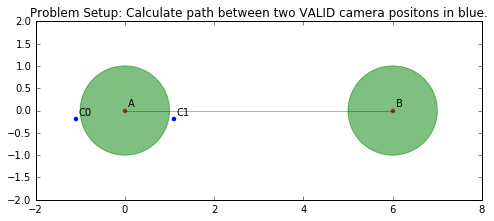

In [135]:
#
# Setting up a desired start and end camera position
#

min_dist = 1                    # let's set a minimum distance of 1m
PA_1 = toric.Vector3(0,0,0)     # person A position
PB_1 = toric.Vector3(6,0,0)     # person B position
C_0 = toric.Vector3(-1.1,-0.2,0)  # Starting camera position is *outside* of PA_1
C_1 = toric.Vector3( 1.1,-0.2,0)    # Ending camera position

drawSetup(fudgeY_neg=2)
plt.title("Problem Setup: Calculate path between two VALID camera positons in blue.")

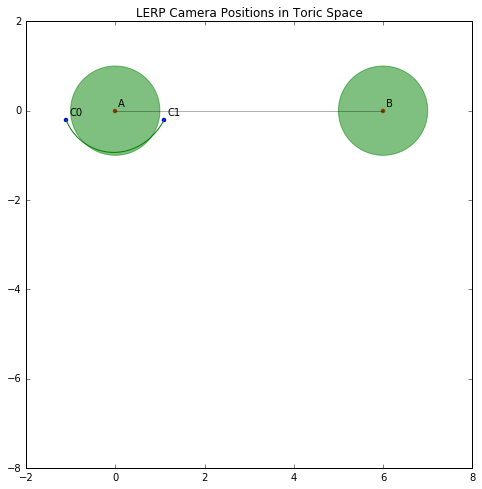

In [136]:
drawSetup()

def map_toric_to_cam(a):
    t = toric.Toric3(toric.RadianPi(a[0]),toric.Radian2Pi(a[1]),toric.RadianPi(a[2]))
    return toric.Toric3_ToWorldPositionNP(t, PA_1, PB_1)

C_0_toric = toric.Toric3_FromWorldPosition(C_0,PA_1,PB_1)
C_1_toric = toric.Toric3_FromWorldPosition(C_1,PA_1,PB_1)

# Alpha is easy to interpolate
alpha_lin = np.linspace(C_0_toric.getAlpha().valueRadians(),C_1_toric.getAlpha().valueRadians())

# Theta we want to interpolate by mapping the space "theta in [0, 2(pi - alpha)]" to "[0,1]", and interpolating in the latter.
# so first we will extract the start and end alphas and equivalent thetas.
theta0 = C_0_toric.getTheta().valueRadians()
theta1 = C_1_toric.getTheta().valueRadians()
theta0_max = 2*(np.pi - C_0_toric.getAlpha().valueRadians())
theta1_max = 2*(np.pi - C_1_toric.getAlpha().valueRadians())

theta0_lerpspace = theta0/theta0_max
theta1_lerpspace = theta1/theta1_max

theta_lerpspace_lin = np.linspace(theta0_lerpspace,theta1_lerpspace)
theta_lin = theta_lerpspace_lin * (2*(np.pi - alpha_lin))

# Phi is easy to interpolate
phi_lin   = np.linspace(C_0_toric.getPhi().valueRadians(),  C_1_toric.getPhi().valueRadians())

P = np.c_[ alpha_lin, theta_lin, phi_lin ]
C = np.apply_along_axis(map_toric_to_cam, axis=1, arr=P)

plt.plot(C[:,0],C[:,1], c="green")

plt.title("LERP Camera Positions in Toric Space")

# Prove that our transition trajectories maintains minimum distance constraint to both subjects.

### Problem Setup:

Given two subjects $\vec{A}$ and $\vec{B}$ and a starting and ending camera position $\vec{C}_0$ and $\vec{C}_1$, calculate a path $\vec{\sigma}(u)$ where $\vec{\sigma}(0) = \vec{C}_0$ and $\vec{\sigma}(1) = \vec{C}_1$. All vectors are in world space $(x,y,z)$. 

$\vec{\sigma}(u)$ needs to satisfy two minimum distance constraints:

$$
\begin{align}
\|\vec{\sigma}(u) - \vec{A}\| && \leq && d_m \\
\|\vec{\sigma}(u) - \vec{B}\| && \leq && d_m
\end{align}
$$

We will calculate $\vec{\sigma}(u)$ as follows:

Consider the simplified interpolation space $(\vec{v}_A(u),\vec{v}_B(u),d_A(u),d_B(u))$ where $\vec{v}_i(u)$ is an interpolation function producting a unit "vantage" vector and $d_i(u)$ is a interpolation function producing a distance along the unit "vantage" vector. 

That is:

$$
\begin{align}
d_A(0) & = \|\vec{C}_0\ - \vec{A}\| \\
d_A(1) & = \|\vec{C}_1\ - \vec{A}\| \\
d_A(u) & = (1 - u)*d_A(0)  + u*d_A(1) \\
\vec{v}_A(0) & = \frac{\vec{C}_0 - \vec{A}}{\|\vec{C}_0 - \vec{A}\|} \\
\vec{v}_A(1) & = \frac{\vec{C}_1 - \vec{A}}{\|\vec{C}_1 - \vec{A}\|} \\
\vec{v}_A(u) & = SLERP(\vec{v}_i(0),\vec{v}_i(1); u)  
\end{align}
$$

and equivalent for $d_B$ and $\vec{v}_B$, where 

$$
u \in (0,1)
$$

### First Consider the Simplified Interpolation Function

We define $\vec{\sigma}(u)$ as

$$
\begin{align}
\vec{\sigma}(u) & = \frac{1}{2}[\vec{A} + \vec{B} + \sum_{i \in (A,B)} d_i(u)\cdot\vec{v}_i(u)] \\
\vec{\sigma}(u) & = \frac{1}{2}[\vec{A} + \vec{B} + d_A(u) \cdot \vec{v}_A(u) + d_B(u) \cdot \vec{v}_B(u)]
\end{align}
$$

Notice this is a simplified version of $F_{A,B}(x)$ presented in Lino et al

### Prove that $\vec{\sigma}(u)$ maintains constraints under certain restrictions on $\vec{C}_0$ and $\vec{C}_1$

Manipulate $\vec{\sigma}(u)$:

$$
\vec{\sigma}(u) = \frac{\vec{\sigma}_A(u) + \vec{\sigma}_B(u)}{2}
$$

where

$$
\begin{align}
\vec{\sigma}_A(u) & = \vec{A} + d_A(u)\vec{v}_A(u) \\
\vec{\sigma}_B(u) & = \vec{B} + d_B(u)\vec{v}_B(u) \\
\end{align}
$$

That is, we consider separately interpolating the components of $\vec{\sigma}(u)$ relating to person $A$ and person $B$

#### Restriction: Consider the case where $\vec{C}_0$ and $\vec{C}_1$ are both on the same side of the line $AB$. 

This occurs when $\vec{v}_A(u) \cdot \text{normal}(B-A)$ and $\vec{v}_B(u) \cdot \text{normal}(B-A)$ have the same sign.


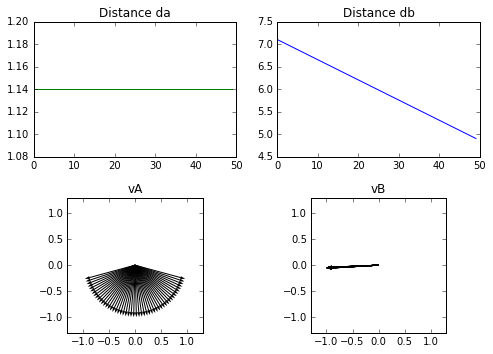

In [62]:
# Create Numpy arrays
A = PA_1.np()
B = PB_1.np()
C0 = C_0.np()
C1 = C_1.np()

# Set up interpolation vector
u = np.c_[np.linspace(0,1)]

# Set up the distance components of sigmaA, sigmaB
dA0 = la.norm(C0 - A)
dA1 = la.norm(C1 - A)
dB0 = la.norm(C0 - B)
dB1 = la.norm(C1 - B)

dA = np.linspace(dA0, dA1)
dB = np.linspace(dB0, dB1)

# Set up the vantage vector components of sigmaA, sigmaB
vA0 = (C0 - A) / dA0
vA1 = (C1 - A) / dA1
vB0 = (C0 - B) / dB0
vB1 = (C1 - B) / dB1

vA = np.apply_along_axis(lambda u : slerp(vA0,vA1,u), axis=1, arr=u)
vB = np.apply_along_axis(lambda u : slerp(vB0,vB1,u), axis=1, arr=u)

# Set up sigmaA, sigmaB, sigma
sigmaA = A + dA[:,np.newaxis] * vA
sigmaB = B + dB[:,np.newaxis] * vB
sigma = (sigmaA + sigmaB) / 2

#
# Graphing the various components of Sigma
#
from matplotlib import gridspec
gs = gridspec.GridSpec(2, 2, width_ratios=[1,1], height_ratios=[1,1,1]) 
fig = plt.figure()

f1 = fig.add_subplot(gs[0])
f2 = fig.add_subplot(gs[1])
f3 = fig.add_subplot(gs[2])
f4 = fig.add_subplot(gs[3])

f1.plot(dA,c="green")
f1.set_title("Distance da")
f2.plot(dB,c="blue")
f2.set_title("Distance db")

f3.quiver(np.linspace(0,0), np.linspace(0,0), vA[:,0],vA[:,1],angles='xy',scale_units='xy',scale=1)
f3.set_ylim([-1.3,1.3])
f3.set_xlim([-1.3,1.3])
f3.set_title("vA")
f3.set_aspect('equal')

f4.quiver(np.linspace(0,0), np.linspace(0,0), vB[:,0],vB[:,1],angles='xy',scale_units='xy',scale=1)
f4.set_ylim([-1.3,1.3])
f4.set_xlim([-1.3,1.3])
f4.set_title("vB")
f4.set_aspect('equal')


## False! Counterexample!

Given a valid start and end camera positions, both on the same side of the line AB, our simplified $\vec{\sigma}(u)$ *doesn't work*.

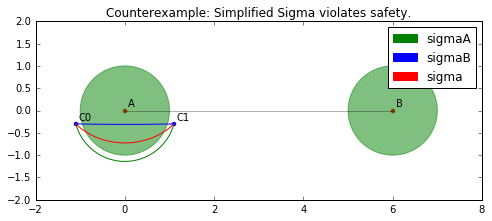

In [63]:

drawSetup(fudgeY_neg=2)
plt.plot(sigmaA[:,0],sigmaA[:,1], c="green")
plt.plot(sigmaB[:,0],sigmaB[:,1], c="blue")
plt.plot(sigma[:,0], sigma[:,1],  c="red")
plt.title("Counterexample: Simplified Sigma violates safety.")

sA_legend = mpatches.Patch(color="green", label="sigmaA")
sB_legend = mpatches.Patch(color="blue", label="sigmaB")
S_legend  = mpatches.Patch(color="red", label="sigma")
plt.legend(handles=[sA_legend,sB_legend,S_legend])


### Second, Consider the Full Interpolation Function

We define $\vec{\sigma}(u)$ as

$$
\vec{\sigma}(u) = \frac{1}{2}[\vec{A} + \vec{B} + \sum_{i \in (A,B)} \vec{v}_i(u) \cdot \frac{d_i(u) + a_{i}(u) \cdot \lambda_i(u)}{1 + \lambda_i(u)}] \\
$$ 

Where we are introducing two new terms. $\lambda_i(u) \in (0,1)$ and $a_{i}(u)$. 

$$
\begin{align}
\lambda_i(u) = \sin(\text{angle between } \vec{v}_i \text{ and } AB) = \frac{\|\vec{v}_i \times AB\|}{\|\vec{v}_i\|\|AB\|}
\end{align}
$$

Notice:

*  if $\lambda_i(u) == 0$, then this full version of $\vec{\sigma}(u)$ is equivalent to the simplified version. 
*  if $\lambda_i(u) == 1$, then the vantage vector $\vec{v}_i(u)$ is scaled by the average of $d_i(u)$ and $a_{i}(u)$

**All the magic lies in $a_{i}(u)$**

#### Prove that $\vec{\sigma}(u)$ maintains constraints under certain restrictions on $\vec{C}_0$ and $\vec{C}_1$

Manipulate $\vec{\sigma}(u)$:

$$
\vec{\sigma}(u) = \frac{\vec{\sigma}_A(u) + \vec{\sigma}_B(u)}{2}
$$

where

$$
\begin{align}
\vec{\sigma}_A(u) & = \vec{A} + \vec{v}_A(u) \cdot \frac{d_A(u) + a_{A}(u) \cdot \lambda_A(u)}{1 + \lambda_A(u)} \\
\vec{\sigma}_B(u) & = \vec{B} + \vec{v}_B(u) \cdot \frac{d_B(u) + a_{B}(u) \cdot \lambda_B(u)}{1 + \lambda_B(u)} \\
\end{align}
$$

That is, we consider separately interpolating the components of $\vec{\sigma}(u)$ relating to person $A$ and person $B$

#### Restriction: Consider the case where $\vec{C}_0$ and $\vec{C}_1$ are both on the same side of the line $AB$. 

This occurs when $\vec{v}_A(u) \cdot \text{normal}(B-A)$ and $\vec{v}_B(u) \cdot \text{normal}(B-A)$ have the same sign.


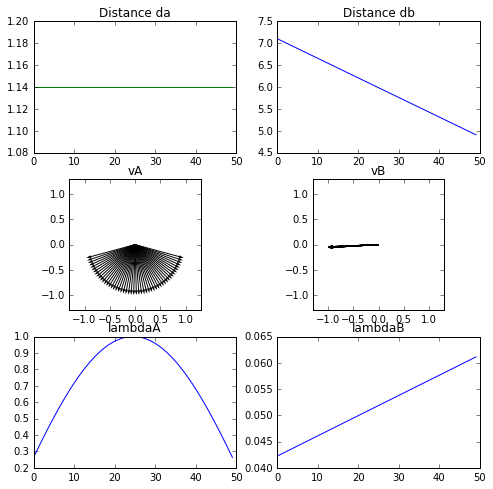

In [112]:
# Create Numpy arrays
A = PA_1.np()
B = PB_1.np()
C0 = C_0.np()
C1 = C_1.np()

# Set up interpolation vector
u = np.c_[np.linspace(0,1)]

# Set up the distance components of sigmaA, sigmaB
dA0 = la.norm(C0 - A)
dA1 = la.norm(C1 - A)
dB0 = la.norm(C0 - B)
dB1 = la.norm(C1 - B)

dA = np.linspace(dA0, dA1)
dB = np.linspace(dB0, dB1)

# Set up the vantage vector components of sigmaA, sigmaB
vA0 = (C0 - A) / dA0
vA1 = (C1 - A) / dA1
vB0 = (C0 - B) / dB0
vB1 = (C1 - B) / dB1

vA = np.apply_along_axis(lambda u : slerp(vA0,vA1,u), axis=1, arr=u)
vB = np.apply_along_axis(lambda u : slerp(vB0,vB1,u), axis=1, arr=u)

# Set up lambda by calculating the sin between the vantage vector v and the line of action AB
AB = B - A
lambdaA = (la.norm(np.cross(vA, AB),axis=1) / (la.norm(vA,axis=1) * la.norm(AB)))
lambdaB = (la.norm(np.cross(vB, AB),axis=1) / (la.norm(vB,axis=1) * la.norm(AB)))


# 
# Set up "a"
# This is the nasty one: We're *also* toric-interpolating the path
# then 
#

# Set up sigmaA, sigmaB, sigma
sigmaA = A + vA * ((dA + lambdaA * dA)/(1 + lambdaA))[:,np.newaxis]
sigmaB = B + vB * dB[:,np.newaxis]
sigma = (sigmaA + sigmaB) / 2

#
# Graphing the various components of Sigma
#
from matplotlib import gridspec
gs = gridspec.GridSpec(3, 2, width_ratios=[1,1], height_ratios=[1,1,1]) 
fig = plt.figure()

f1 = fig.add_subplot(gs[0])
f2 = fig.add_subplot(gs[1])
f3 = fig.add_subplot(gs[2])
f4 = fig.add_subplot(gs[3])
f5 = fig.add_subplot(gs[4])
f6 = fig.add_subplot(gs[5])

f1.plot(dA,c="green")
f1.set_title("Distance da")
f2.plot(dB,c="blue")
f2.set_title("Distance db")

f3.quiver(np.linspace(0,0), np.linspace(0,0), vA[:,0],vA[:,1],angles='xy',scale_units='xy',scale=1)
f3.set_ylim([-1.3,1.3])
f3.set_xlim([-1.3,1.3])
f3.set_title("vA")
f3.set_aspect('equal')

f4.quiver(np.linspace(0,0), np.linspace(0,0), vB[:,0],vB[:,1],angles='xy',scale_units='xy',scale=1)
f4.set_ylim([-1.3,1.3])
f4.set_xlim([-1.3,1.3])
f4.set_title("vB")
f4.set_aspect('equal')

f5.plot(lambdaA)
f5.set_title("lambdaA")

f6.plot(lambdaB)
f6.set_title("lambdaB")

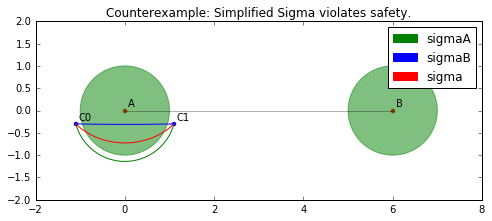

In [113]:
drawSetup(fudgeY_neg=2)
plt.plot(sigmaA[:,0],sigmaA[:,1], c="green")
plt.plot(sigmaB[:,0],sigmaB[:,1], c="blue")
plt.plot(sigma[:,0], sigma[:,1],  c="red")
plt.title("Counterexample: Simplified Sigma violates safety.")

sA_legend = mpatches.Patch(color="green", label="sigmaA")
sB_legend = mpatches.Patch(color="blue", label="sigmaB")
S_legend  = mpatches.Patch(color="red", label="sigma")
plt.legend(handles=[sA_legend,sB_legend,S_legend])
